In [12]:
!pip install kagglehub torch torchvision -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torch import nn
import kagglehub
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load Anime & Sketch Datasets

anime_path = kagglehub.dataset_download("vincentv/anime-style-transfer")
sketch_path = kagglehub.dataset_download("almightyj/person-face-sketches")

print("Path to Anime Style Dataset:", anime_path)
print("Path to Sketch Style Dataset:", sketch_path)

Path to Anime Style Dataset: /kaggle/input/anime-style-transfer
Path to Sketch Style Dataset: /kaggle/input/person-face-sketches


In [6]:
# Pre-processing & DataLoaders

latent_dim   = 32
lr           = 1e-3
weight_decay = 1e-5
num_epochs   = 20
lambda_mmd   = 10.0
IMG_SIZE     = 64

anime_root  = '/kaggle/input/anime-style-transfer'
sketch_root = '/kaggle/input/person-face-sketches'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class PairedDataset(Dataset):
    def __init__(self, root_dir, input_subfolder, target_subfolder, transform=None):
        self.input_dir  = os.path.join(root_dir, input_subfolder)
        self.target_dir = os.path.join(root_dir, target_subfolder)
        self.files      = sorted(os.listdir(self.input_dir))
        self.transform  = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_in  = Image.open(os.path.join(self.input_dir,  fname)).convert('RGB')
        img_out = Image.open(os.path.join(self.target_dir, fname)).convert('RGB')
        if self.transform:
            img_in  = self.transform(img_in)
            img_out = self.transform(img_out)
        return img_in, img_out

In [7]:
# Anime Style DataLoaders

anime_base = os.path.join(anime_root, 'anime-style-transfer')

def make_anime_loader(split, bs=32):
    base = os.path.join(anime_root, 'anime-style-transfer', split)
    return DataLoader(
        PairedDataset(base, 'images', 'labels', transform),
        batch_size=bs,
        shuffle=(split=='train'),
        num_workers=0,
        pin_memory=True
    )


anime_train_loader = make_anime_loader('train')
anime_test_loader  = make_anime_loader('test')


# Sketch Style DataLoaders

def make_sketch_loader(split, bs=32):
    return DataLoader(
        PairedDataset(sketch_root, f'{split}/photos', f'{split}/sketches', transform),
        batch_size=bs,
        shuffle=(split=='train'),
        num_workers=0,
        pin_memory=True
    )

sketch_train_loader = make_sketch_loader('train')
sketch_test_loader  = make_sketch_loader('test')


for name, loader in [
    ('anime_train',  anime_train_loader),
    ('anime_test',   anime_test_loader),
    ('sketch_train', sketch_train_loader),
    ('sketch_test',  sketch_test_loader),
]:
    x, y = next(iter(loader))
    print(f"{name}: in {x.shape}, out {y.shape}")

anime_train: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
anime_test: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
sketch_train: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
sketch_test: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])


In [8]:
# WAE

class ConvWAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,  32, 4,2,1), nn.ReLU(True),
            nn.Conv2d(32, 64, 4,2,1), nn.ReLU(True),
            nn.Conv2d(64,128, 4,2,1), nn.ReLU(True),
            nn.Conv2d(128,256, 4,2,1), nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_z         = nn.Linear(256*4*4, latent_dim)
        self.decoder_input= nn.Linear(latent_dim, 256*4*4)
        self.decoder      = nn.Sequential(
            nn.Unflatten(1, (256,4,4)),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  3, 4,2,1), nn.Tanh()
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.fc_z(h)
        out = self.decoder(self.decoder_input(z))
        return out, z

def gaussian_kernel(x, y, sigma=1.0):
    x, y = x.view(x.size(0), -1), y.view(y.size(0), -1)
    xx = x.unsqueeze(1); yy = y.unsqueeze(0)
    dist2 = (xx - yy).pow(2).sum(-1)
    return torch.exp(-dist2 / (2*sigma**2))

def mmd_loss(z, z_p, sigma=1.0):
    Kzz = gaussian_kernel(z,   z,   sigma)
    Kpp = gaussian_kernel(z_p, z_p, sigma)
    Kzp = gaussian_kernel(z,   z_p, sigma)
    return Kzz.mean() + Kpp.mean() - 2*Kzp.mean()

def wae_loss(recon, target, z, lambda_mmd=lambda_mmd):
    recon_l = nn.functional.mse_loss(recon, target, reduction='sum') / recon.size(0)
    z_p     = torch.randn_like(z)
    mmd     = mmd_loss(z, z_p, sigma=1.0)
    return recon_l + lambda_mmd * mmd

In [9]:
# Train/Test Function

def run_wae_training(model, optimizer, train_loader, test_loader):
    for epoch in range(1, num_epochs+1):

        model.train()
        train_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Train {epoch}/{num_epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, z = model(x)
            loss   = wae_loss(out, y, z, lambda_mmd)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(test_loader, desc=f"Test  {epoch}/{num_epochs}"):
                x, y = x.to(device), y.to(device)
                out, z = model(x)
                test_loss += wae_loss(out, y, z, lambda_mmd).item()
        test_loss /= len(test_loader)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train: {train_loss:.4f}  Test: {test_loss:.4f}")

In [10]:
# Anime Training

anime_wae = ConvWAE(latent_dim).to(device)
anime_opt = torch.optim.Adam(anime_wae.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

run_wae_training(anime_wae, anime_opt,
                 anime_train_loader, anime_test_loader)

Train 1/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  1/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 01/20 | Train: 3561.7035  Test: 3109.4484


Train 2/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  2/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/20 | Train: 2667.3214  Test: 2459.6184


Train 3/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  3/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/20 | Train: 2295.0859  Test: 2212.7816


Train 4/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  4/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/20 | Train: 2170.7219  Test: 2095.6282


Train 5/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  5/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/20 | Train: 2082.9157  Test: 2011.5913


Train 6/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  6/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/20 | Train: 2043.3420  Test: 2023.0787


Train 7/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  7/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/20 | Train: 2032.2997  Test: 1995.1412


Train 8/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  8/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/20 | Train: 1988.2651  Test: 2005.8506


Train 9/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  9/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/20 | Train: 1974.0460  Test: 1938.0524


Train 10/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  10/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train: 1965.9656  Test: 1970.6313


Train 11/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  11/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train: 1953.4527  Test: 1996.8013


Train 12/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  12/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train: 1924.4728  Test: 1911.7815


Train 13/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  13/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train: 1911.3669  Test: 1939.8857


Train 14/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  14/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train: 1921.5753  Test: 1900.2622


Train 15/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  15/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train: 1915.4609  Test: 1924.2666


Train 16/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  16/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train: 1911.0796  Test: 1951.3438


Train 17/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  17/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train: 1903.1868  Test: 1919.8754


Train 18/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  18/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train: 1898.0066  Test: 1931.2911


Train 19/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  19/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train: 1881.2235  Test: 1867.7251


Train 20/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  20/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train: 1878.5385  Test: 1857.1657


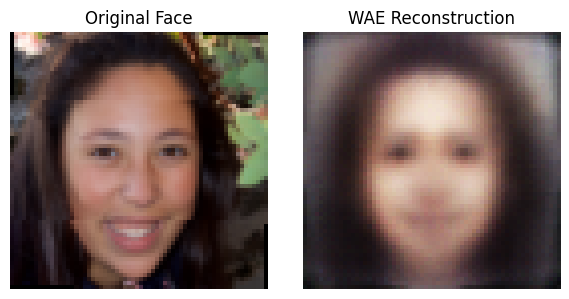

In [14]:
# Testing Anime Style Transformation

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0,1)

img_path = '/content/drive/My Drive/test_face.jpg'
pil_img  = Image.open(img_path).convert('RGB')
x = transform(pil_img).unsqueeze(0).to(device)

anime_wae.eval()

with torch.no_grad():
    recon, z = anime_wae(x)

inp = denormalize(x.cpu()[0])
out = denormalize(recon.cpu()[0])

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].imshow(inp.permute(1,2,0))
axs[0].set_title('Original Face')
axs[0].axis('off')

axs[1].imshow(out.permute(1,2,0))
axs[1].set_title('WAE Anime Reconstruction')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Sketch Training

num_epochs = 5

sketch_wae = ConvWAE(latent_dim).to(device)
sketch_opt = torch.optim.Adam(sketch_wae.parameters(),
                              lr=lr,
                              weight_decay=weight_decay)

run_wae_training(sketch_wae, sketch_opt,
                 sketch_train_loader, sketch_test_loader)

Train 1/5:   0%|          | 0/646 [00:00<?, ?it/s]

Test  1/5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 01/5 | Train: 1841.9070  Test: 1705.0838


Train 2/5:   0%|          | 0/646 [00:00<?, ?it/s]

Test  2/5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 02/5 | Train: 1706.8262  Test: 1674.3062


Train 3/5:   0%|          | 0/646 [00:00<?, ?it/s]

Test  3/5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 03/5 | Train: 1687.9996  Test: 1685.0658


Train 4/5:   0%|          | 0/646 [00:00<?, ?it/s]

Test  4/5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 04/5 | Train: 1678.5451  Test: 1641.8080


Train 5/5:   0%|          | 0/646 [00:00<?, ?it/s]

Test  5/5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 05/5 | Train: 1667.3882  Test: 1665.8862


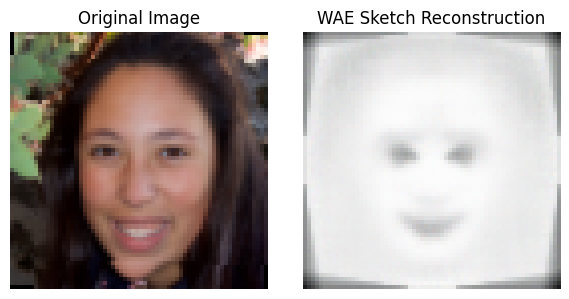

In [17]:
# Testing Sketch Style Transformation

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0,1)

img_path = '/content/drive/My Drive/test_face.jpg'
pil_img  = Image.open(img_path).convert('RGB')

x = transform(pil_img).unsqueeze(0).to(device)

sketch_wae.eval()

with torch.no_grad():
    recon, z = sketch_wae(x)

inp = denormalize(x.cpu()[0])
out = denormalize(recon.cpu()[0])

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].imshow(inp.permute(1,2,0))
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(out.permute(1,2,0))
axs[1].set_title('WAE Sketch Reconstruction')
axs[1].axis('off')

plt.tight_layout()
plt.show()